## 13. 비모수적 모델


### import

In [1]:
import numpy as np
import pandas as pd
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

for i in [np, pd, mpl, sns, sklearn]:
    print(i.__name__, i.__version__)

numpy 1.18.5
pandas 0.25.1
matplotlib 3.5.3
seaborn 0.12.2
sklearn 0.21.3


### 예제 데이터셋 준비

In [2]:
df_spam = pd.read_csv('data/SMSSpamCollection.tsv', sep='\t')
df_spam.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df_titanic = pd.read_csv('data/titanic.csv', index_col='PassengerId')
# 전처리: Pclass와 Embarked를 가변수화 합니다.
# Embarked의 결측치는 최빈값으로,
# Age의 결측치는 평균으로 대체합니다.
# 범주형 변수는 가변수화하여 수치형 변수화 동일하게 취급합니다.
# Sex은 female, male 두 개의 범주이므로 이진형으로 바꿉니다.
df_titanic = pd.get_dummies(
    df_titanic.assign(
        Embarked = lambda x: x['Embarked'].fillna(x['Embarked'].mode().iloc[0]),
        Age = lambda x: x['Age'].fillna(x['Age'].mean()),
    ), columns=['Pclass', 'Embarked']
).assign(
    Sex = lambda x: x['Sex'] == 'female'
)
# 머신러닝에 사용할 변수들을 정리합니다.
X_num = ['Age', 'SibSp', 'Parch', 'Fare']
X_dum = [i for i in df_titanic.columns if i.startswith('Pclass') or i.startswith('Sex') or i.startswith('Embarked')]
X_all = X_num + X_dum
X_all

['Age',
 'SibSp',
 'Parch',
 'Fare',
 'Sex',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S']

### 1. 의사결정나무(Decision Tree)

#### 의사결정나무

- 데이터를 단계적인 분기(Split)에 따라 예측하는 트리(나무) 구조의 모델

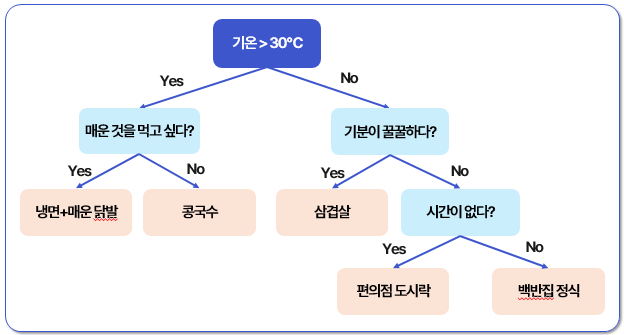

#### 구성요소

- 내부 노드(Internal Node): 분기 조건을 지닌 노드
- 루트 노드(Root Node): 최상위 내부 노드
- 가지(Branch): 노드와 노드의 연결 관계
- 리프 노드(Leaf Node): 최종 예측 결과를 지닌 노드

#### 학습: 재귀적 분할(Recursive Splitting) 기반

- 학습 시작: 분기(전체데이터)
- 욕심쟁이(Greedy) 알고리즘으로 최적의 구조를 갖는 나무를 학습하는 것은 보장되지 않음
- 분기(Splitting)

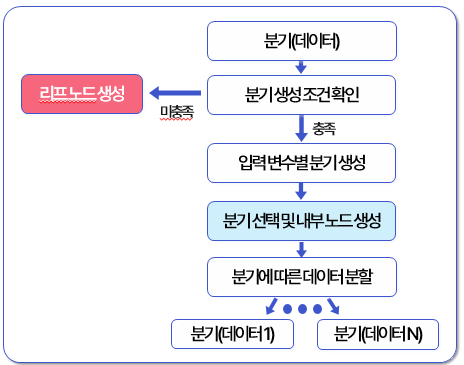

#### 학습: 사전 가지치기(Pruning)

- 사전 가지치기: 나무의 복잡도를 분기 생성 이전에 제한

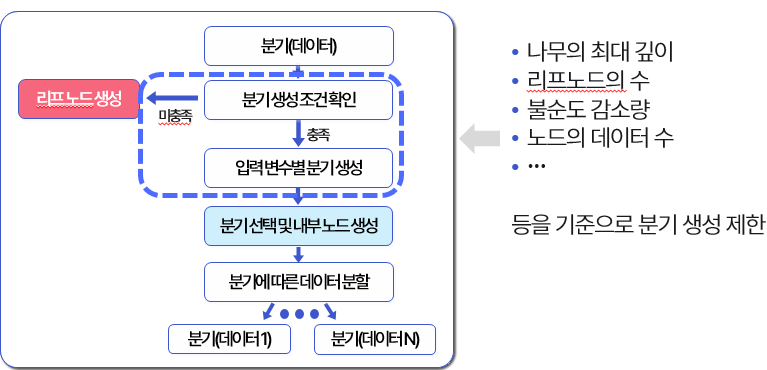

In [4]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_titanic, train_size=0.8, stratify=df_titanic['Survived'], random_state=123)

**[Ex.1]**

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

max_depth 에 따라 학습과 평가의 성능이 어떻게 변하는지 확인합니다.

입력 변수는 X_all 리스트에 있는 변수이고, 대상 변수는 Survived 입니다.

성능 측정 지표는 정확도(Accuracy) 입니다.

```
max_depths = np.arange(2, 13)
```
    
</div>

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

max_depths = np.arange(2, 13)
acc_train, acc_test = list(), list()
for max_depth in max_depths:
    clf_dt = DecisionTreeClassifier(max_depth=max_depth, random_state=123)
    clf_dt.fit(df_train[X_all], df_train['Survived'])
    acc_test.append(
        accuracy_score(df_test['Survived'], clf_dt.predict(df_test[X_all]))
    )
    acc_train.append(
        accuracy_score(df_train['Survived'], clf_dt.predict(df_train[X_all]))
    )

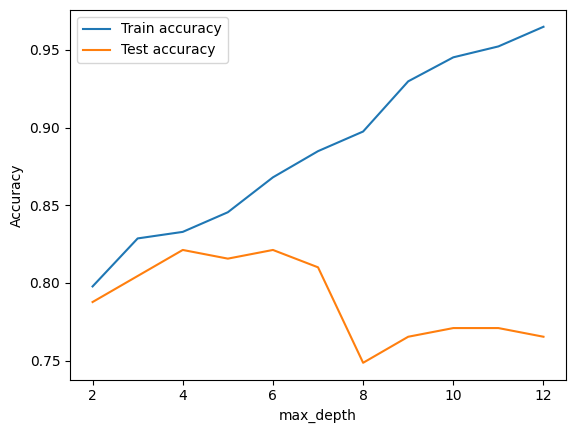

In [6]:
plt.plot(max_depths, acc_train, label='Train accuracy')
plt.plot(max_depths, acc_test, label='Test accuracy')
plt.gca().set_xlabel('max_depth')
plt.gca().set_ylabel('Accuracy')
plt.legend()
plt.show()

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

max_leaf_nodes 에 따라 학습과 평가의 성능이 어떻게 변하는지 확인합니다.


```
max_leaf_nodes_list = np.arange(2, 10) ** 2
```
</div>

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

max_leaf_nodes_list = np.arange(2, 10) ** 2
acc_train, acc_test = list(), list()
for max_leaf_nodes in max_leaf_nodes_list:
    clf_dt = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, random_state=123)
    clf_dt.fit(df_train[X_all], df_train['Survived'])
    acc_test.append(
        accuracy_score(df_test['Survived'], clf_dt.predict(df_test[X_all]))
    )
    acc_train.append(
        accuracy_score(df_train['Survived'], clf_dt.predict(df_train[X_all]))
    )

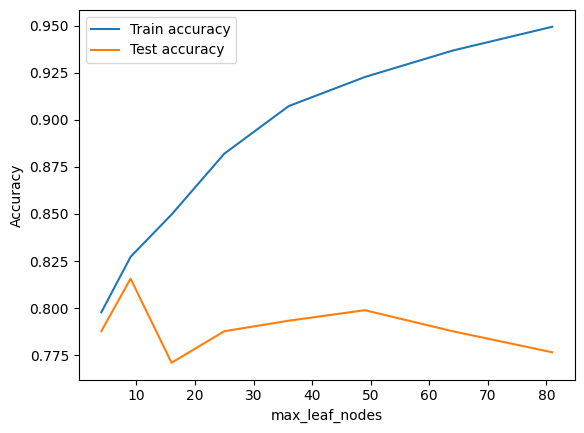

In [8]:
plt.plot(max_leaf_nodes_list, acc_train, label='Train accuracy')
plt.plot(max_leaf_nodes_list, acc_test, label='Test accuracy')
plt.gca().set_xlabel('max_leaf_nodes')
plt.gca().set_ylabel('Accuracy')
plt.legend()
plt.show()

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

min_samples_leaf 에 따라 학습과 평가의 성능이 어떻게 변하는지 확인합니다.


```
min_samples_leafs = np.arange(2, 33, 2)
```
</div>

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

min_samples_leafs  = np.arange(2, 64, 4)
acc_train, acc_test = list(), list()
for min_samples_leaf in min_samples_leafs :
    clf_dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, random_state=123)
    clf_dt.fit(df_train[X_all], df_train['Survived'])
    acc_test.append(
        accuracy_score(df_test['Survived'], clf_dt.predict(df_test[X_all]))
    )
    acc_train.append(
        accuracy_score(df_train['Survived'], clf_dt.predict(df_train[X_all]))
    )

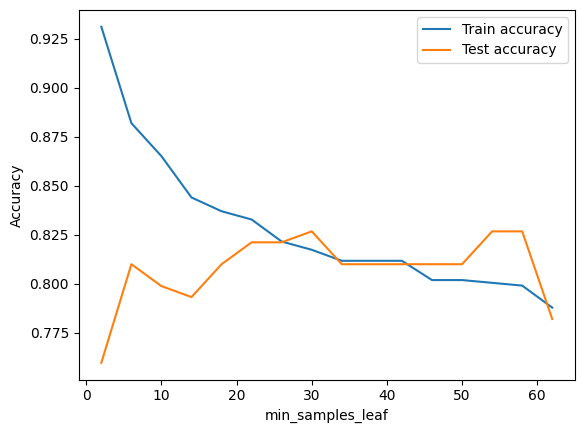

In [10]:
plt.plot(min_samples_leafs, acc_train, label='Train accuracy')
plt.plot(min_samples_leafs, acc_test, label='Test accuracy')
plt.gca().set_xlabel('min_samples_leaf')
plt.gca().set_ylabel('Accuracy')
plt.legend()
plt.show()

#### 학습: 분기 선택 기준(Criterion)

- 불순도 감소량(Impurity Reduction)

> $\Delta I = I - \sum_{k=1}^{K} \frac{N_k}{N} I_k$
>
>$I$:노드의데이터의 불순도 $N$:데이터수 $K$:분기의수
>
>$N_k$:k분기에해당하는데이터수 $I_k$:k분기에해당하는데이터의불순도

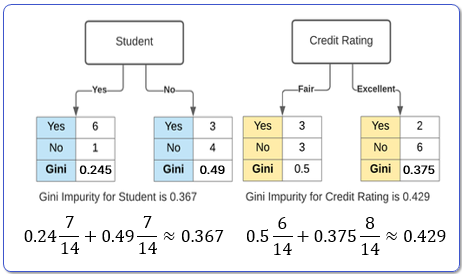

- 카이 제곱검정의 p-value
- 분산분석(ANOVA)의 p-value


#### 학습: 분기 선택 기준(Criterion)

- 분류(Classification)

> 민감도: 지니 불순도 < 엔트로피
>
> ▷ 엔트로피가 지니 불순도에 비해 과적합 위험이 큼

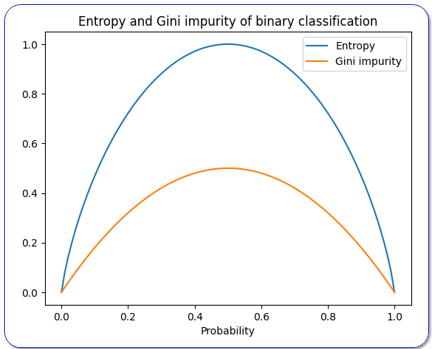

- 회귀(Regression)

| | 평균제곱오차<br>(Mean Squared Error) | 평균절대오차<br>(Mean Absolute Error) |
|---|---|---|
| 수식 | $\frac{1}{n}\sum_{i=1}^{n} (y_i - \bar{y})^2$<br>$\bar{y}$: 평균 | $\frac{1}{n}\sum_{i=1}^{n} \vert y_i - \bar{y} \vert$<br>$\bar{y}$: 중양값 |
| 특징 | 계산이 단순<br>이상치에 영향을 많이 받음 | 계산이 복잡<br>이상치에 영향을 덜 받음 |

#### 학습: 분기의 생성

|   | 이지 분리<br/>(Binary Split) | 다지 분리<br/>(Multi-Way Split) |
| --- | --- | --- |
| 의미 | 두 개의 가지 생성 | 이상의 가지 생성 |
| 분기 조건 |   | 각 범주마다 분기 생성 |
| 트리 깊이 | 깊어짐 | 얕아짐 |
| 과적합 위험 | 보다 유연하게 대응이 가능 | 범주의 수가 많을 때 심해짐 |
| 연속형 변수 | 정렬 후 인접한 값들과의 중간값 중에서<br/>불순도 감소폭이 가장 큰 값을 기준으로 분리 | 구간화가 쉽지 않아<br/>거의 사용되지 않음 |


**[Ex.2]**

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

분기점 별 좌측 노드와 우측 노드의 엔트로피 구하기

1. 변수 x의 모든 분기 지점을 구합니다.
   
> 등장하는 숫자 집합을 구합니다. ${a_1, a_2, ..., a_n}$  모든 i에 대해서 $a_{i} < a_{i + 1}$ 입니다.
>
> 모든 i에 대해여, $a_i$와 $a_{i+1}$ 사이의 중간값으로 분기점을 만듭니다.: $b_{i} = \frac{a_i + a_{i+1}}{2}$

2. 분기점 별로 좌측 노드의 대상 클래스 빈도수를 구합니다.


3. 분기점 별로 좌측 노드의 클래스 빈도수를 이용하여, 좌/우측 노드의 불순도를 구합니다.


df_titanic의 Parch 변수의 Survived에 대한 분기를 만듭니다.

</div>

In [11]:
def entropy(x):
    """
    엔트로피를 구합니다.
    Parameters:
        x: array-like
    Returns:
        float: 엔트로피
    """
    return -np.sum(x * np.log2(np.where(x > 0, x, 1)))

def gini(x):
    """
    지니 불순도를 구합니다.
    Parameters:
        x: array-like
    Returns:
        float: 지니불순도
    """
    return 1 - np.sum(x ** 2)

# df_titanic에서 Survived의 불순도르 구합니다.
imp_func = entropy # entropy를 불순도로 사용합니다.
#imp_func = gini
imp_t = imp_func(df_titanic['Survived'].value_counts(normalize=True))
imp_t

0.9607079018756469

In [12]:
# Parch에 등장하는 숫자에서 고유값을 구하고 이를 정렬합니다.: a1 ~ an 구하기
u = pd.Series(df_titanic['Parch'].unique()).sort_values()
# Parch에 등장하는 숫자에서 만들 수 있는 분기점을 구합니다.
# 효율적이고 간편하게 분기점별 좌측 노드의 클래스 빈도수를 구하기 위해
# 모든 bi 와 bi+1 분기 구간에 등장하는 클래스 빈도수를 구하고
# 이를 분기 구간별로 정렬된 상태에서 
# 빈도수의 누계를 구하여 bi+1를 기준으로 좌측 노드의 클래스의 빈도와 우측 노드의 클새스의 빈도를 구합니다.
b = np.array([-np.inf] + ((u + u.shift(1)) / 2).dropna().tolist() + [np.inf])
n = len(df_titanic)
df_cnt = pd.crosstab(
    index = pd.cut(df_titanic['Parch'], bins=b, right=True),
    columns = df_titanic['Survived']
).cumsum().rename(index=lambda x: "Parch <= {}".format(x.right))
df_cnt

Survived,0,1
Parch,,
Parch <= 0.5,445,233
Parch <= 1.5,498,298
Parch <= 2.5,538,338
Parch <= 3.5,540,341
Parch <= 4.5,544,341
Parch <= 5.5,548,342
Parch <= inf,549,342


In [13]:
# 좌측 노드의 불순도와 가중치를 구합니다.
df_cnt.apply(
    lambda x: pd.Series([imp_func(x / x.sum()), x.sum() / n], index=['imp', 'weight']), axis=1
)

,imp,weight
Parch,,
Parch <= 0.5,0.928276,0.760943
Parch <= 1.5,0.953970,0.893378
Parch <= 2.5,0.962066,0.983165
Parch <= 3.5,0.962876,0.988777
Parch <= 4.5,0.961707,0.993266
Parch <= 5.5,0.961002,0.998878
Parch <= inf,0.960708,1.000000


In [14]:
# 좌측 노드와 우측 노드의 불순도를 가중합을 구합니다.
df_imp = df_cnt.apply(
    lambda x: imp_func(x / x.sum()) * x.sum() / n, axis=1
) + \
(df_titanic['Survived'].value_counts() - df_cnt).apply(
    lambda x: imp_func(x / x.sum()) * x.sum() / n, axis=1
)
df_imp

Parch
Parch <= 0.5    0.945327
Parch <= 1.5    0.958460
Parch <= 2.5    0.959954
Parch <= 3.5    0.957333
Parch <= 4.5    0.959608
Parch <= 5.5    0.959923
Parch <= inf    0.960708
dtype: float64

In [15]:
# 불순도 감소를 계산합니다. imp_t 분기 이전의 불순도
imp_t - df_imp

Parch
Parch <= 0.5    0.015381
Parch <= 1.5    0.002248
Parch <= 2.5    0.000754
Parch <= 3.5    0.003375
Parch <= 4.5    0.001100
Parch <= 5.5    0.000785
Parch <= inf    0.000000
dtype: float64

**[Ex.3]**

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

df_titanic 에서 gini 불순도를 사용하여 X_all 변수 리스트 각각의 Surivived 대한 불순도 차감을 구해봅니다.

그리고 sklearn.tree.DecisionTreeClassifier 를 X_all을 입력 변수로 대상 변수 Surivied를 최대 깊이(max_depth)를 1로 설정하여 학습하고,

나무를 출력하여 직접 계산한 결과와 비교해봅니다.
    
</div>

In [16]:
def ig(s, s_target, imp_func):
    """
    불순도 차감을 계산합니다.
    위 과정을 종합하여 하나의 함수로 정리했습니다.
    Parameters:
        s: pd.Series
            Series 
        s_target: pd.Series
            대상 변수의 Series
        imp_func: function
            불순도 계산 함수
    Returns:
        pd.Series
        ig: 불순도 차감, imp1: 좌측 영역의 불순도, imp2: 우측 영역의 불순도, n1: 좌측 영역의 데이터수, n2: 우측 영역의 데이터수
    """
    u = pd.Series(s.unique()).sort_values() # 컬럼의 유일값을 구하고, 정렬합니다.
    if len(u) == 1:
        return None
    b = np.array([-np.inf] + ((u + u.shift(1)) / 2).dropna().tolist() + [np.inf]) # 분류 경계를 구합니다.
    n = len(s)
    # 분류 경계점별 불순도를 구하기 위해 구간별 대상 변수(s_target)의 빈도의 누계를 구합니다.
    df_cnt = pd.crosstab(
        index = pd.cut(s, bins=b, right=True),
        columns = s_target
    ).cumsum()
    vcnt = df_cnt.iloc[-1].values
    imp_t = imp_func(vcnt / n) # 분류 경계별 불순도를 구합니다.
    df_cnt = df_cnt.iloc[:-1]
    def ig_sub(x):
        """
        불순도를 구합니다.
        Parameters:
            x: array-like
                데이터
        Returns:
            pd.Series
            imp: 불순도, imp_by_weight:  가중치 * 불순도, n: 데이터 수
        """
        s_ = x.sum()
        imp = imp_func(x / s_)
        return pd.Series([imp, imp * s_ / n, s_], index=['imp', 'imp_by_weight', 'n'])
    # 우측 영역의 불순도를 구합니다.
    df_left = df_cnt.apply(ig_sub, axis=1)
    # 좌측영역의 불순도를 구합니다.
    df_right = (vcnt - df_cnt).apply(ig_sub, axis=1)
    return pd.concat([
        (imp_t - df_left['imp_by_weight'] - df_right['imp_by_weight']).rename('ig'),
        df_left['imp'].rename('imp1'),
        df_right['imp'].rename('imp2'),
        df_left['n'].rename('n1'),
        df_right['n'].rename('n2')
    ], axis=1)

In [17]:
df_imp = ig(df_titanic['Pclass_1'], df_titanic['Survived'], entropy)
display(df_imp)
# 최대 불순도 감소를 보인 분기점을 구합니다.
df_imp.loc[df_imp['ig'].idxmax()]

,ig,imp1,imp2,n1,n2
Pclass_1,,,,,
"(-inf, 0.5]",0.057796,0.887537,0.950956,675.0,216.0


ig        0.057796
imp1      0.887537
imp2      0.950956
n1      675.000000
n2      216.000000
Name: (-inf, 0.5], dtype: float64

In [18]:
max_ig = list()
# 모든 변수에서 최적의 분기점(불순도 감소가 가장 큰)을 구합니다.
for i in X_all:
    df_imp = ig(df_titanic[i], df_titanic['Survived'], gini)
    if df_imp is None:
        continue
    midx = df_imp['ig'].idxmax()
    max_ig.append(
        df_imp.loc[midx].rename(i + '<=' + str(midx.right))
    )
    
df_ig = pd.concat(max_ig, axis=1).T
df_ig

,ig,imp1,imp2,n1,n2
Age<=6.5,0.011283,0.418289,0.464149,47.0,844.0
SibSp<=0.5,0.006350,0.452194,0.497746,608.0,283.0
Parch<=0.5,0.010278,0.451114,0.499724,678.0,213.0
Fare<=10.481,0.042584,0.317157,0.499993,339.0,552.0
Sex<=0.5,0.139648,0.306444,0.382835,577.0,314.0
Pclass_1<=0.5,0.038665,0.424094,0.466392,675.0,216.0
Pclass_2<=0.5,0.004122,0.461179,0.498523,707.0,184.0
Pclass_3<=0.5,0.049138,0.493387,0.367246,400.0,491.0
Embarked_C<=0.5,0.013389,0.451576,0.494260,723.0,168.0
Embarked_Q<=0.5,0.000006,0.472759,0.475628,814.0,77.0


In [19]:
df_ig.loc[df_ig['ig'] == df_ig['ig'].max()]

,ig,imp1,imp2,n1,n2
Sex<=0.5,0.139648,0.306444,0.382835,577.0,314.0


In [20]:
df_ig['ig'].idxmax()

'Sex<=0.5'

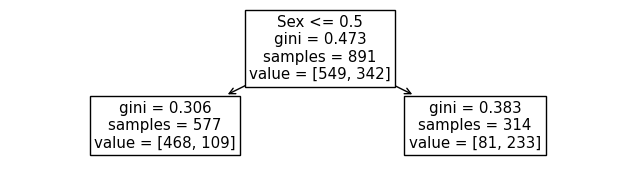

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

plt.figure(figsize=(8, 2))

clf_dt = DecisionTreeClassifier(max_depth=1)
clf_dt.fit(df_titanic[X_all], df_titanic['Survived'])
plot_tree(clf_dt, feature_names=X_all)
plt.show()

In [22]:
# Tree의 성장 루틴을 위해 

def make_split(X, y, imp_func, depth, params):
    if 'max_depth' in params and params.get('max_depth') < depth:
        return None
    if params.get('min_samples_split', 2) >= len(X):
        return None
    max_ig = list()
    # 모든 변수에서 최적의 분기점(불순도 감소가 가장 큰)을 구합니다.
    for i in X.columns:
        df_imp = ig(X[i], y, imp_func)
        if df_imp is None:
            continue
        midx = df_imp['ig'].idxmax()
        max_ig.append(
            df_imp.loc[midx].rename(i + '<=' + str(midx.right))
        )
    if len(max_ig) == 0:
        return None
    qry = 'ig > 0'
    if 'min_samples_leaf' in params:
        v = params.get('min_samples_leaf', 1)
        qry += 'and n1 >= {} and n2 >= {}'.format(v, v)
    df_split = pd.concat(max_ig, axis=1).T.query(qry)
    if len(df_split) == 0:
        return None
    return df_split
df_split = make_split(df_titanic[X_all], df_titanic['Survived'], gini, 1, {'min_samples_leaf': 256})
df_split

,ig,imp1,imp2,n1,n2
SibSp<=0.5,0.006350,0.452194,0.497746,608.0,283.0
Fare<=10.481,0.042584,0.317157,0.499993,339.0,552.0
Sex<=0.5,0.139648,0.306444,0.382835,577.0,314.0
Pclass_3<=0.5,0.049138,0.493387,0.367246,400.0,491.0


In [23]:
def make_leaf_node(y):
    return y.mode()[0]

#### 학습: 나무의 성장 방식


|   | 레벨(깊이)기준 나무 성장<br/>(Level(Depth)-Wise /Breadth-First Tree Growth) | 성능 기준 나무 성장<br/>(Leaf-Wise / Best(Depth)-First Tree Growth) |
| --- | --- | --- |
| 방식 |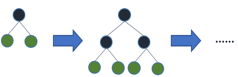|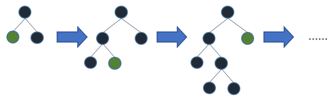|
| 특징 | 과적합 위험이 상대적으로 낮음<br/>병렬화 용이<br/>비효율적 노드의 생성 가능성이 높음 | 효율이 높은 나무를 생성<br/>과적합 위험이 상대적으로 높음<br/>병렬화가 어려움<br/>불균형 성장으로 인한 병목 현상이 생길 수 있음 |

- 출처: https://lightgbm.readthedocs.io/en/latest/Features.html

- 나무의 성장 방식에 따른 의사 결정 나무의 구현

> max_leaf_nodes가 주어지면 성능 기준의 성장이고, 그렇지 않으면 레벨 기준 성장을 하도록 나무를 구성합니다.

In [24]:
import heapq

class LimitedKeyPriorityQueue:
    def __init__(self, key):
        """
        key: item -> 비교에 사용할 값(또는 tuple)을 반환하는 함수
        예) key=lambda x: (x[0], x[2])  # 0번, 2번 요소만 비교에 사용
        """
        self.key = key
        self._heap = []
        self._counter = 0  # tie-breaker (삽입 순서 유지용)

    def push(self, item):
        # 비교에 사용할 key만 뽑아서 heap에 넣는다
        k = self.key(item)
        heapq.heappush(self._heap, (k, self._counter, item))
        self._counter += 1

    def pop(self):
        if not self._heap:
            raise IndexError("pop from empty priority queue")
        k, _, item = heapq.heappop(self._heap)
        return item

    def __len__(self):
        return len(self._heap)

    def is_empty(self):
        return len(self._heap) == 0

In [25]:
class TreeNode():
    def __init__(self, split):
        self.left = None
        self.right = None
        self.a, self.b = split.split('<=')
        self.b = float(self.b)
        
    def set_left(self, node):
        self.left = node

    def set_right(self, node):
        self.right = node
        
    def predict(self, x):
        if x[self.a] <= self.b:
            if not isinstance(self.left, TreeNode):
                return self.left
            return self.left.predict(x)
        if not isinstance(self.right, TreeNode):
            return self.right
        return self.right.predict(x)

class Tree():
    def __init__(self):
        self.root = None
    def set_root(self, node):
        self.root = node
    def predict(self, X):
        return X.apply(lambda x: self.root.predict(x), axis=1)

def build_tree(X, y, imp_func, params):
    level_wise = 'max_leaf_nodes' not in params
    max_leaf_nodes = params.get('max_leaf_nodes', np.inf)
    pq = LimitedKeyPriorityQueue(
        key=lambda item: (item[0], item[1])  # priority, deadline만 비교
    )
    root = Tree()
    def set_root(x):
        root.set_root(x)
    df_split = make_split(X, y, imp_func, 1, params)
    if df_split is None:
        return make_leaf_node(y)
    if level_wise:
        l1, l2 = 1, -df_split['ig'].max()
    else:
        l1, l2 = -df_split['ig'].max(), 1
    pq.push(
        (l1, l2, (X, y, 0, df_split['ig'].idxmax(), set_root))
    )
    n_leaf_nodes = 0
    while len(pq) > 0:
        l1, l2, (X_sub, y_sub, depth, split, func) = pq.pop()
        s_eval = X_sub.eval(split)
        X_left, y_left = X_sub.loc[s_eval], y_sub.loc[s_eval]
        X_right, y_right = X_sub.loc[~s_eval], y_sub.loc[~s_eval]
        df_split_left = make_split(X_left, y_left, imp_func, depth + 1, params)
        df_split_right = make_split(X_right, y_right, imp_func, depth + 1, params)
        if df_split_left is None and df_split_right is None:
            func(make_leaf_node(y_sub))
            n_leaf_nodes += 1
            continue
        if n_leaf_nodes + len(pq) + 2 >  max_leaf_nodes:
            func(make_leaf_node(y_sub))
            break
        node = TreeNode(split)
        func(node)
        if df_split_left is None:
            node.set_left(make_leaf_node(y_left))
            n_leaf_nodes += 1
        else:    
            if level_wise:
                l1_next, l2_next = l1 + 1, -df_split_left['ig'].max()
            else:
                l1_next, l2_next = -df_split_left['ig'].max(), l2 + 1
            pq.push((l1_next, l2_next, (X_left, y_left, depth + 1, df_split_left['ig'].idxmax(), node.set_left)))
        
        if df_split_right is None:
            node.set_right(make_leaf_node(y_right))
            n_leaf_nodes += 1
        else:
            if level_wise:
                l1_next, l2_next = l1 + 1, -df_split_right['ig'].max()
            else:
                l1_next, l2_next = -df_split_right['ig'].max(), l2 + 1
            pq.push((l1_next, l2_next, (X_right, y_right, depth + 1, df_split_right['ig'].idxmax(), node.set_right)))
    while len(pq) > 0:
        l1, l2, (X_sub, y_sub, depth, split, func) = pq.pop()
        func(make_leaf_node(y_sub))
    return root

In [26]:
tree = build_tree(df_titanic[X_all], df_titanic['Survived'], gini, {'max_depth': 3})

In [27]:
def print_tree(node, depth=0):
    indent = "  " * depth  # depth만큼 들여쓰기
    
    # Leaf node 판별: TreeNode가 아닌 경우 leaf로 간주
    if not isinstance(node, TreeNode):
        print(f"{indent}Leaf: {node}")
        return
    
    # 현재 node 출력
    print(f"{indent}Split: {node.a} <= {node.b}")
    
    # Left child
    print(f"{indent}├── Left:")
    print_tree(node.left, depth + 1)
    
    # Right child
    print(f"{indent}└── Right:")
    print_tree(node.right, depth + 1)

print_tree(tree.root)

Split: Sex <= 0.5
├── Left:
  Split: Age <= 6.5
  ├── Left:
    Split: SibSp <= 2.5
    ├── Left:
      Leaf: 1
    └── Right:
      Leaf: 0
  └── Right:
    Split: Pclass_1 <= 0.5
    ├── Left:
      Leaf: 0
    └── Right:
      Leaf: 0
└── Right:
  Split: Pclass_3 <= 0.5
  ├── Left:
    Split: Age <= 2.5
    ├── Left:
      Leaf: 0
    └── Right:
      Leaf: 1
  └── Right:
    Split: Fare <= 23.35
    ├── Left:
      Leaf: 1
    └── Right:
      Leaf: 0


In [28]:
tree = build_tree(df_titanic[X_all], df_titanic['Survived'], gini, {'max_leaf_nodes': 8})

In [29]:
print_tree(tree.root)

Split: Sex <= 0.5
├── Left:
  Split: Age <= 6.5
  ├── Left:
    Split: SibSp <= 2.5
    ├── Left:
      Leaf: 1
    └── Right:
      Leaf: 0
  └── Right:
    Leaf: 0
└── Right:
  Split: Pclass_3 <= 0.5
  ├── Left:
    Leaf: 1
  └── Right:
    Split: Fare <= 23.35
    ├── Left:
      Split: Age <= 36.5
      ├── Left:
        Leaf: 1
      └── Right:
        Leaf: 0
    └── Right:
      Split: Parch <= 0.5
      ├── Left:
        Leaf: 1
      └── Right:
        Leaf: 0


In [30]:
(tree.predict(df_titanic[X_all]) == df_titanic['Survived']).mean()

0.8338945005611672

**[Ex.4]**

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

df_titanic에서 입력 변수를 X_all 대상 변수를 Survived로 했을 때,

레벨 기준 성장 방법과 성능 기준 성장 방법의 차이점을 확인해봅니다.

</div>

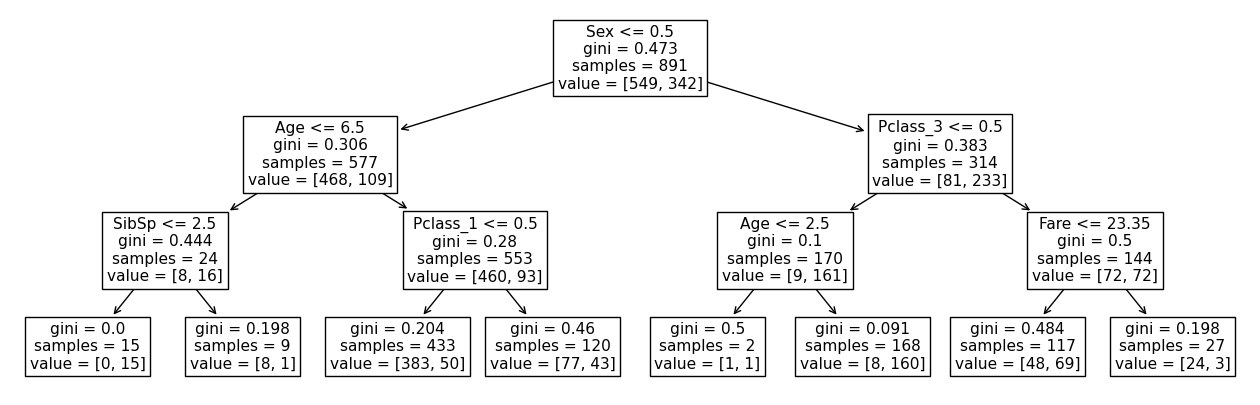

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(16, 5))

clf_dt = DecisionTreeClassifier(max_depth=3, random_state=123)
clf_dt.fit(df_titanic[X_all], df_titanic['Survived'])
plot_tree(clf_dt, feature_names=X_all)
plt.show()

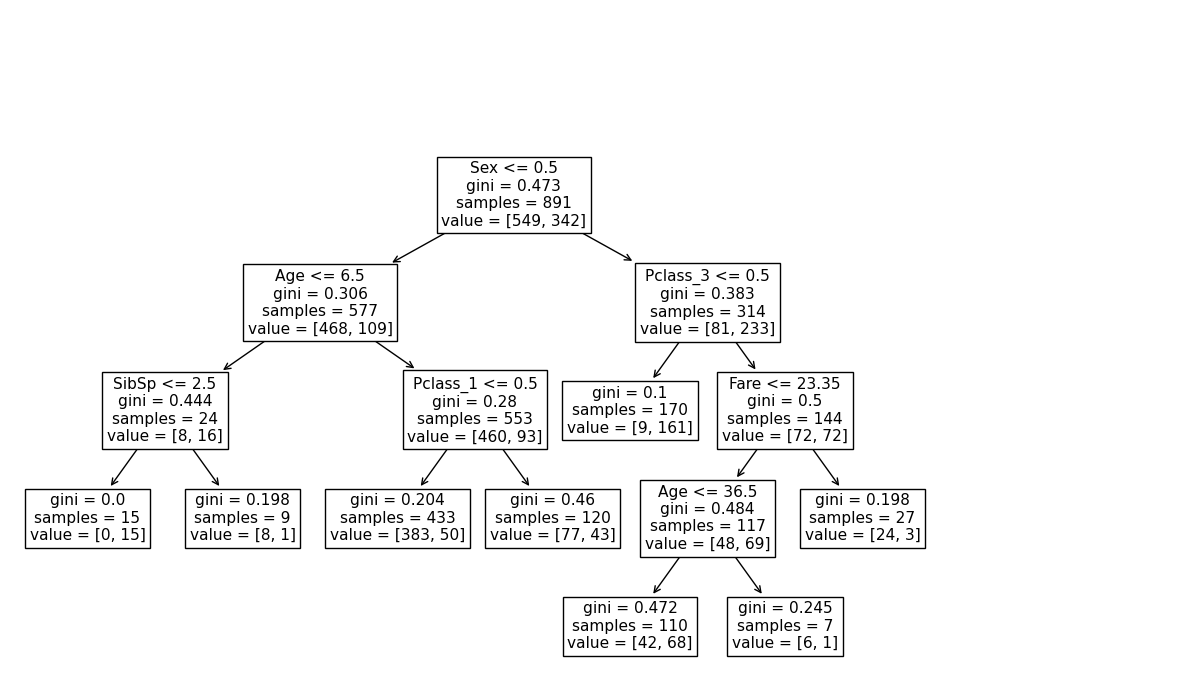

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(12, 7))
clf_dt = DecisionTreeClassifier(max_leaf_nodes=8, max_depth = None)
clf_dt.fit(df_titanic[X_all], df_titanic['Survived'])
plot_tree(clf_dt, feature_names=X_all)

plt.tight_layout()
plt.show()

#### 학습: 가지치기(Pruning)

- 사후 가지치기(Post-Pruning): 학습 완료 후 리프 노드들을 분기 이전으로 돌렸을 때의 효율성과 비교하여

비용 복잡도 가지치기(Cost Complexity Pruning)

$R_{\alpha(T)} = R(T) + \alpha|T|$

$R(T)$:나무T의 총손실

$|T|$:나무T의 리프노드수

$\alpha$:복잡도제어계수

#### 종류

|   | ID3 | C4.5 | CHAID<br/>Chi-squared Automatic Interaction | CART<br/>Classification and Regression Tree |
| --- | --- | --- | --- | --- |
| 분기 | 다지 분기 | 다지 분기 | 다지 분기 | 이지 분기 |
| 연속형 변수 처리 | 미지원 | 임계값 기준 분할 | 구간화 | 임계값 기준 분할 |
| 불순도 기준 | 정보 이득(Information Gain) | 정보 이득 비율(Gain Ratio) | 카이 제곱 통계량<br/>F 검정 통계량 | 지니 불순도 감소량<br/>정보 이득 |
| 지원 학습 유형 | 분류 | 분류 | 분류 및 회귀 | 분류 및 회귀 |
| 가지치기 | 지원 안 함 | 지원 | 지원 | 지원 |
| 결측값 처리 | 미지원 | 가능 | 가능 | 가능 |



#### 장단점

| 장점 | 단점 |
| --- | --- |
| 직관적 해석 가능성<br/>전처리 부담 낮음<br/>특성 선택 내재화 | 과적합이 쉽게 발생<br/>작은 변화에 민감<br/>고차원 및 복잡한 경계 표현 한계<br/>등장하지 않은 유형의 데이터에는 불안정적 |


### 2. K-최근접 이웃
- 예측할 데이터 포인트의 K 개의 이웃들의 대상 변수를 바탕으로 예측


#### Tie Breaking

- 분류 문제에서 이웃의 클래스 빈도에 동수가 존재할 때 해소법

> 가까운 이웃 우선
> 
> 임의 선택
> 
> 고정 순위 사용: 클래스 빈도, 클래스 명 사전순,...
> 
> 이진 분류인 경우 K 를 홀수로 설정


#### Ex) 분류
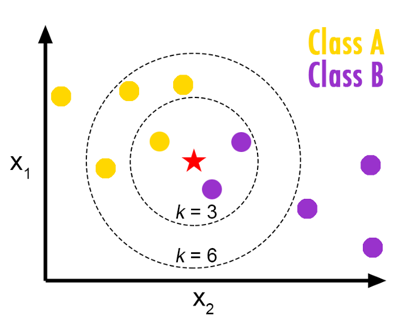

- K 가 3 이고 균일 분류일 때, Class B
- K 가 6 이고 균일 분류일 때, Class A

#### 특징
- 인스턴스 기반(Instance-Based): 학습 데이터 예측 시 활용
- Lazy Learning: 예측 시 학습 데이터와 연산을 통해 예측
- Local Generalization: 지역적 정보로 일반화

#### K 값에 따른 분산과 편향의 변화

| K 값 | 분산 | 편향 |
| --- | --- | --- |
| 작을수록 | 높다→ 데이터에 민감 | 낮다 |
| 높을수록 | 낮다 | 높다 → 세밀함 부족 |

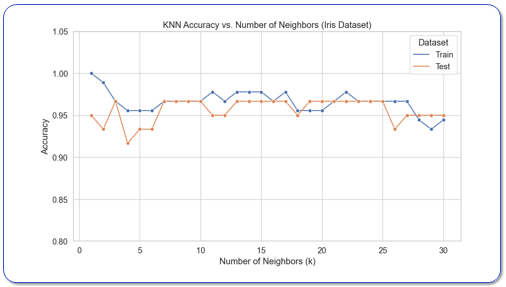

#### 장단점

| 장점 | 단점 |
| --- | --- |
| 직관적 이해<br/>비선형 패턴 학습 가능 | 차원 저주 현상에 취약<br/>스케일 민감성<br/>클래스 불균형에 취약<br/>학습 데이터 전체 저장 필요<br/>예측이 느림 |

#### 차원의 저주(Curse of Dimensionality)

- 데이터 밀도의 희박화
> 차원이 커질수록 최소 거리와 최장 거리의 비율이 1 에 수렴
- 거리 기반 판단의 무력화
> 결과의 신뢰도를 유지하기 위해 더 많은 데이터가 필요하게 됨


**[Ex.5]**

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

df_spam에서 80%를 학습 데이터 df_train으로 나머지 20%는 평가 데이터는 df_test로 나누어 봅니다. 


K-최근접 이웃모델로 바꾸고 근접이웃의 수를 아래 리스트에 따라 바꿀 때, df_train과 df_test의 성능 변화를 관찰해봅니다. 

최소한 5건의 메세지에서 등장한 단어의 빈도를 입력 변수(속성)을 만듭니다.

성능 측정 지표는 Accuracy입니다.

```
n_neighbors_list = [1, 3, 5, 10, 20, 50, 100]
```
    
</div>

In [33]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_spam, train_size=0.8, random_state=123)

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

cvec = CountVectorizer(lowercase=True, min_df=5)
X_train = cvec.fit_transform(df_train['message'])
X_test =cvec.transform(df_test['message'])
n_neighbors_list = [1, 3, 5, 10, 20, 50, 100]
acc_train, acc_test = list(), list()

for i in n_neighbors_list:
    clf_knn = KNeighborsClassifier(
        n_neighbors=i,
        metric='euclidean'
    )
    clf_knn.fit(X_train, df_train['target'])
    acc_test.append(
        accuracy_score(df_test['target'], clf_knn.predict(X_test))
    )
    acc_train.append(
        accuracy_score(df_train['target'], clf_knn.predict(X_train))
    )

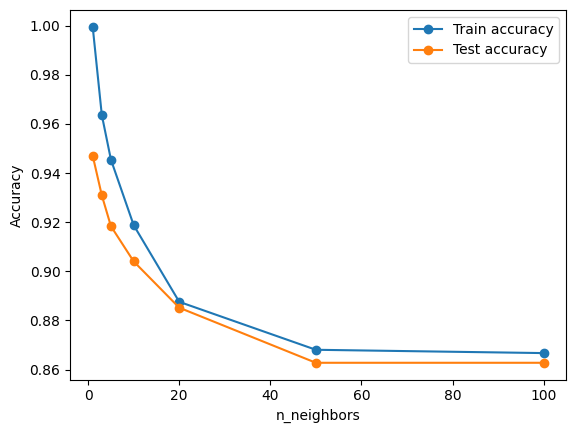

In [35]:
plt.plot(n_neighbors_list, acc_train, label='Train accuracy', marker='o')
plt.plot(n_neighbors_list, acc_test, label='Test accuracy', marker='o')
plt.gca().set_xlabel('n_neighbors')
plt.gca().set_ylabel('Accuracy')
plt.legend()
plt.show()